## Sentence Modality Notebook

### Imported libraries

In [1]:
import os
import urllib.request
import zipfile
import xml.etree.ElementTree as ET

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import random as rd

import pydot
import graphviz

import tensorflow as tf
from keras.utils import plot_model
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense
from keras.callbacks import TensorBoard,ModelCheckpoint,Callback
from keras import backend as K

/Applications/anaconda/envs/nlp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dl_PATH = './downloads/'

### Functions for downloading and unzipping modality data
All data is saved to the downloads file so as to not be uploaded to github.

In [3]:
def maybe_download(url, name):
    
    global dl_PATH
    
    if not os.path.exists(dl_PATH):
        os.makedirs(dl_PATH)
        
    if os.path.isfile(dl_PATH+name):
        print(name+' already downloaded.')
    else:
        try:
            urllib.request.urlretrieve(url, dl_PATH+name)
            print(name+' successfully downloaded.')
        except:
            print('Error downloading '+name+'.')
        
def maybe_unzip(zname):
    global dl_PATH
    
    if not os.path.isfile(dl_PATH+'task1_train_bio_abstracts_rev2.xml'):
        with zipfile.ZipFile(dl_PATH+zname, 'r') as zipref:
            zipref.extractall(dl_PATH)
    else:
        print(zname+' already unzipped.')

In [4]:
maybe_download('http://rgai.inf.u-szeged.hu/~vinczev/conll2010st/task1_train_bio_rev2.zip', 'task1_train_bio.zip')
maybe_unzip('task1_train_bio.zip') #'task1_train_bio_abstracts_rev2.xml' and 'task1_train_bio_fullarticles_rev2.xml'

task1_train_bio.zip already downloaded.
task1_train_bio.zip already unzipped.


### Class/functions definitions for handling .xml data files
The data is presented in an xml file format and is processed here into an ElementTree. The element tree behaves similarly to a nested list structure with a few extra methods.


In [5]:
class TextData(object):
    def __init__(self, xml):
        with open(dl_PATH+xml) as fd:
            self.ETree = ET.parse(fd)
            
    def totaldocNo(self):
        return(len(self.get_documents()))
        
    def totsentNo(self):
        N = 0
        for doc in self.getdocuments():
            N += len(doc[2][:])
        return(N)
    
    def get_docs(self, start=None, stop=None):
        return(self.ETree.getroot()[0][start:stop])
    
    def tosent(doc):
        return(doc[2][:])
    
    def get_sentences(self):
        sentences = []
        for doc in self.get_docs():
            for part in doc[1:]:
                for sent in part[:]:
                    sentences.append(sent)
        return(sentences)

def toString(sentElement):
    sent = sentElement.text
    if sent == None:
        sent = ''
    ccuelen = len(sentElement.getchildren())
    if ccuelen > 0:
        for i in range(ccuelen):
            sent += sentElement[i].text
            sent += sentElement[i].tail
    return(sent)

def toStrings(sentElements):
    strings = []
    for element in sentElements:
        strings.append(toString(element))
    return(strings)
    
def isCertain(sentElement):
    if sentElement.attrib['certainty'] == 'certain':
        return(True)
    else:
        return(False)
    
def get_cues(sentElement):
    return sentElement.getchildren()

def num_words(string):
    return len(text_to_word_sequence(string,
                                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                     lower=True,
                                     split=" "))

def cue_positions(sentElement):
    pos = 0
    positions = []
    pos += num_words(toString(sentElement))
    for cue in get_cues(sentElement)[::-1]:
        pos -= num_words(cue.tail)
        pos -= num_words(cue.text)
        positions.append(pos)
    return(positions[::-1])


In [6]:
data = TextData('task1_train_bio_abstracts_rev2.xml')    

In [7]:
sentences = data.get_sentences()
sentence_lengths = []
for sentence in toStrings(sentences):
    sentence_lengths.append(num_words(sentence))

In [8]:
fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.gca()
ax1.set_title('Sentence Length Distribution')
ax1.set_ylabel('Number of sentences')
ax1.set_xlabel('Number of words')
plt.hist(sentence_lengths,bins=81,range=(0,80),color=[0.7,0.1,0.2])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [9]:
def word2index(words, embed_dict):
    # Takes a list of words and indexes them, returning a list of integers.
    indexed = []
    for word in words:
        try:
            indexed.append(embed_dict[word])
        except KeyError:
            indexed.append(embed_dict['UNK'])
    return(indexed)

In [32]:
def generate_batches(sentences, maxlen, batchsize, embed_dict):
    # Creates a list of input data for training the RNN. 
    # Each batch contains sentences with lengths binned into mulitples of 10.

    max_size = int((maxlen+9)/10)
    size_grouped = []
    certainties_grouped = []
    for i in range(max_size):
        size_grouped.append([])
        certainties_grouped.append([])
    for sentence in sentences:
        string = toString(sentence)
        words = text_to_word_sequence(string,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True,
                          split=" ")
        size = int((len(words)+9)/10)
        if size <= max_size:
            indexed_words = word2index(words,embed_dict)
            certainty = isCertain(sentence)
            size_grouped[size-1].append(indexed_words)
            certainties_grouped[size-1].append([int(not certainty),int(certainty)])
    batches = []
    
    sizehistx = []
    sizehisty = []
    l = 0
    for i in range(len(size_grouped)):
        l+=10
        sizehistx.append(str(l))
        rd.seed(447)
        rd.shuffle(size_grouped[i])
        rd.seed(447)
        rd.shuffle(certainties_grouped[i])
        
        numbatch = int(len(size_grouped[i])/batchsize)+1
        sizehisty.append(numbatch)
        size_grouped[i].extend(size_grouped[i][:10])
        certainties_grouped[i].extend(certainties_grouped[i][:10])
        for j in range(numbatch):
            padded = pad_sequences(size_grouped[i][(j)*batchsize:(j+1)*batchsize],
                                   maxlen=l,
                                   dtype='int32',
                                   padding='pre',
                                   truncating='pre',
                                   value=0)
            
            batches.append([padded, np.array(certainties_grouped[i][(j)*batchsize:(j+1)*batchsize])])
    fig2 = plt.figure(figsize=(7,3))
    ax2 = fig2.gca()
    ax2.set_title('Number of Batches per Sentence Length')
    ax2.set_ylabel('Number of batches')
    ax2.set_xlabel('Number of words')
    plt.bar(sizehistx,sizehisty,color=[0.7,0.1,0.2])
    plt.tight_layout()
    plt.show()
    return(batches)      

In [33]:
embed_dict={}
index=0
with open('./logs/word2vec_label.tsv', 'r') as fr:
    data = fr.readlines()
    for word in data:
        embed_dict[word[:-1]]=index
        index+=1

<IPython.core.display.Javascript object>


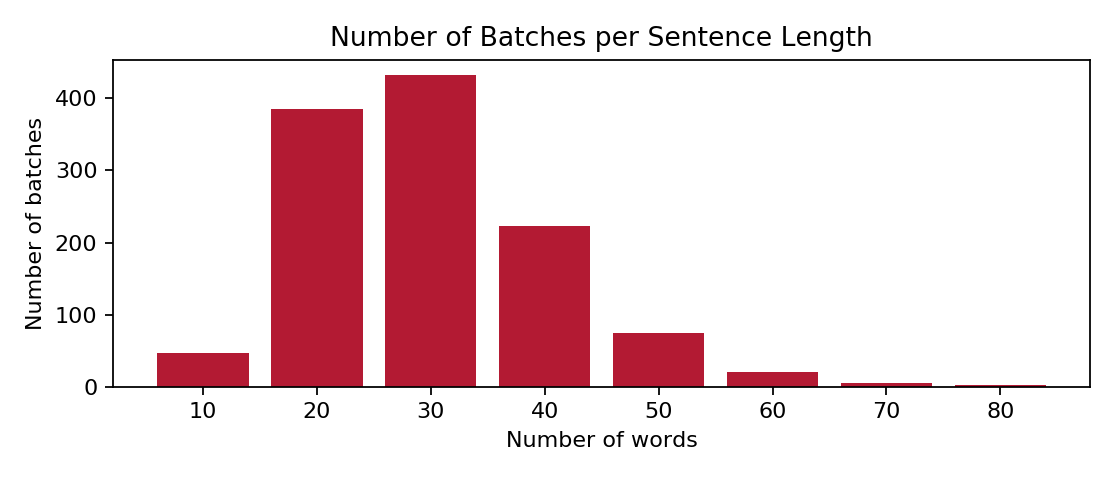

In [34]:
batches = generate_batches(sentences,80,10,embed_dict)
rd.shuffle(batches)

In [13]:
vocab_size = 5000
embedding_dimension = 32
batch_size = 10

### LSTM Model
![Graph of LSTM Model](./images/modalityLSTMmodel.png)

In [14]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dimension,name='word2vec',trainable=True))
model.add(LSTM(30, 
               activation='tanh', # activation function used
               recurrent_activation='hard_sigmoid', # activation function for recurrent step
               use_bias=True, # whether the layer uses a bias vector
               kernel_initializer='glorot_uniform', # initialiser for the weights matrix
               recurrent_initializer='orthogonal', # initialiser for the recurrent kernal's weights
               bias_initializer='zeros', # initialiser for the bias vector
               unit_forget_bias=True, # add 1 to the bias of the forget gate at initialization
               kernel_regularizer=None, # regularizer function applied to kernal
               recurrent_regularizer=None, # regularizer function applied to recurrent kernal
               bias_regularizer=None, # regularizer function applied to bias vector
               activity_regularizer=None, # regularizer function applied to output of the layer
               kernel_constraint=None, # constraint function applied to the kernal
               recurrent_constraint=None, # constraint function applied to the recurrent kernal
               bias_constraint=None, # constraint function applied to the bias vector
               dropout=0.0, # fraction of units to drop for the linear transformation of the inputs
               recurrent_dropout=0.0, # fraction of units to drop for the linear transformation of the recurrent state
               implementation=1, # implementation mode, either 1 or 2.
               return_sequences=False, 
               return_state=False, 
               go_backwards=False, 
               stateful=False, # If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
               unroll=False)) # whether the network will be unrolled, otherwise a symbolic loop will be used.
model.add(Dense(2,
                activation='softmax', 
                use_bias=True, 
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros', 
                kernel_regularizer=None, 
                bias_regularizer=None, 
                activity_regularizer=None, 
                kernel_constraint=None, 
                bias_constraint=None))
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy', 
              metrics=['acc'], 
              sample_weight_mode=None, 
              weighted_metrics=None, 
              target_tensors=None)
model.load_weights('./logs/wordvec_model.h5',by_name=True)
model.summary()
plot_model(model, to_file='./images/modalityLSTMmodel.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word2vec (Embedding)         (None, None, 32)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 62        
Total params: 167,622
Trainable params: 167,622
Non-trainable params: 0
_________________________________________________________________


In [15]:
tensorboard = TensorBoard(log_dir='./logs/modality', batch_size=batch_size, 
                          histogram_freq=1, write_images=True, 
                          write_grads=False, write_graph=True, embeddings_freq=1)
model_checkpoint = ModelCheckpoint('./logs/modalityLSTMmodel.h5')

[0.11972146, 1.0]

In [36]:
i=0
for batch in batches:
    i+=1
    if i%100 == 0: print(i)
    [x,y] = batches[30]
    model.train_on_batch(x,y)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
